In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#installing pytorch ignite library. helps to simplify training
#no need to write a custom training loop while using this library
!pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 6.2 MB/s eta 0:00:00


In [ ]:
#importing required modules
import torch
import torchvision
from torchvision import datasets,transforms
from torch import nn,optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
import numpy as np

In [ ]:
#importing pytorch ignite

from ignite.engine import Engine,Events,create_supervised_trainer,create_supervised_evaluator
from ignite.handlers import ModelCheckpoint,EarlyStopping
from ignite.metrics import Accuracy,Loss,RunningAverage,ConfusionMatrix

In [ ]:
#loading data
#create a helper function to do so
def get_data_loaders(data_dir,batch_size):
  transform = transforms.Compose([transforms.Resize(255),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor()
                                  ])
  #changing so that it can be used in the model
  all_images = datasets.ImageFolder(data_dir,transform = transform)
  train_images_len = int(len(all_images)*0.80) # 80% of the images will be training
  valid_images_len = int((len(all_images)-train_images_len)/2)
  test_images_len = (int(len(all_images) - train_images_len - valid_images_len))
  train_data,val_data,test_data = random_split(all_images,[train_images_len,valid_images_len,test_images_len])
  train_loader = DataLoader(train_data,batch_size=batch_size)
  val_loader = DataLoader(val_data,batch_size=batch_size)
  test_loader = DataLoader(test_data,batch_size=batch_size)
  return (train_loader,val_loader,test_loader),all_images.classes

In [ ]:
(train_loader,val_loader,test_loader),classes = get_data_loaders('/content/drive/MyDrive/archive-eyes',128)

In [ ]:
print(classes)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


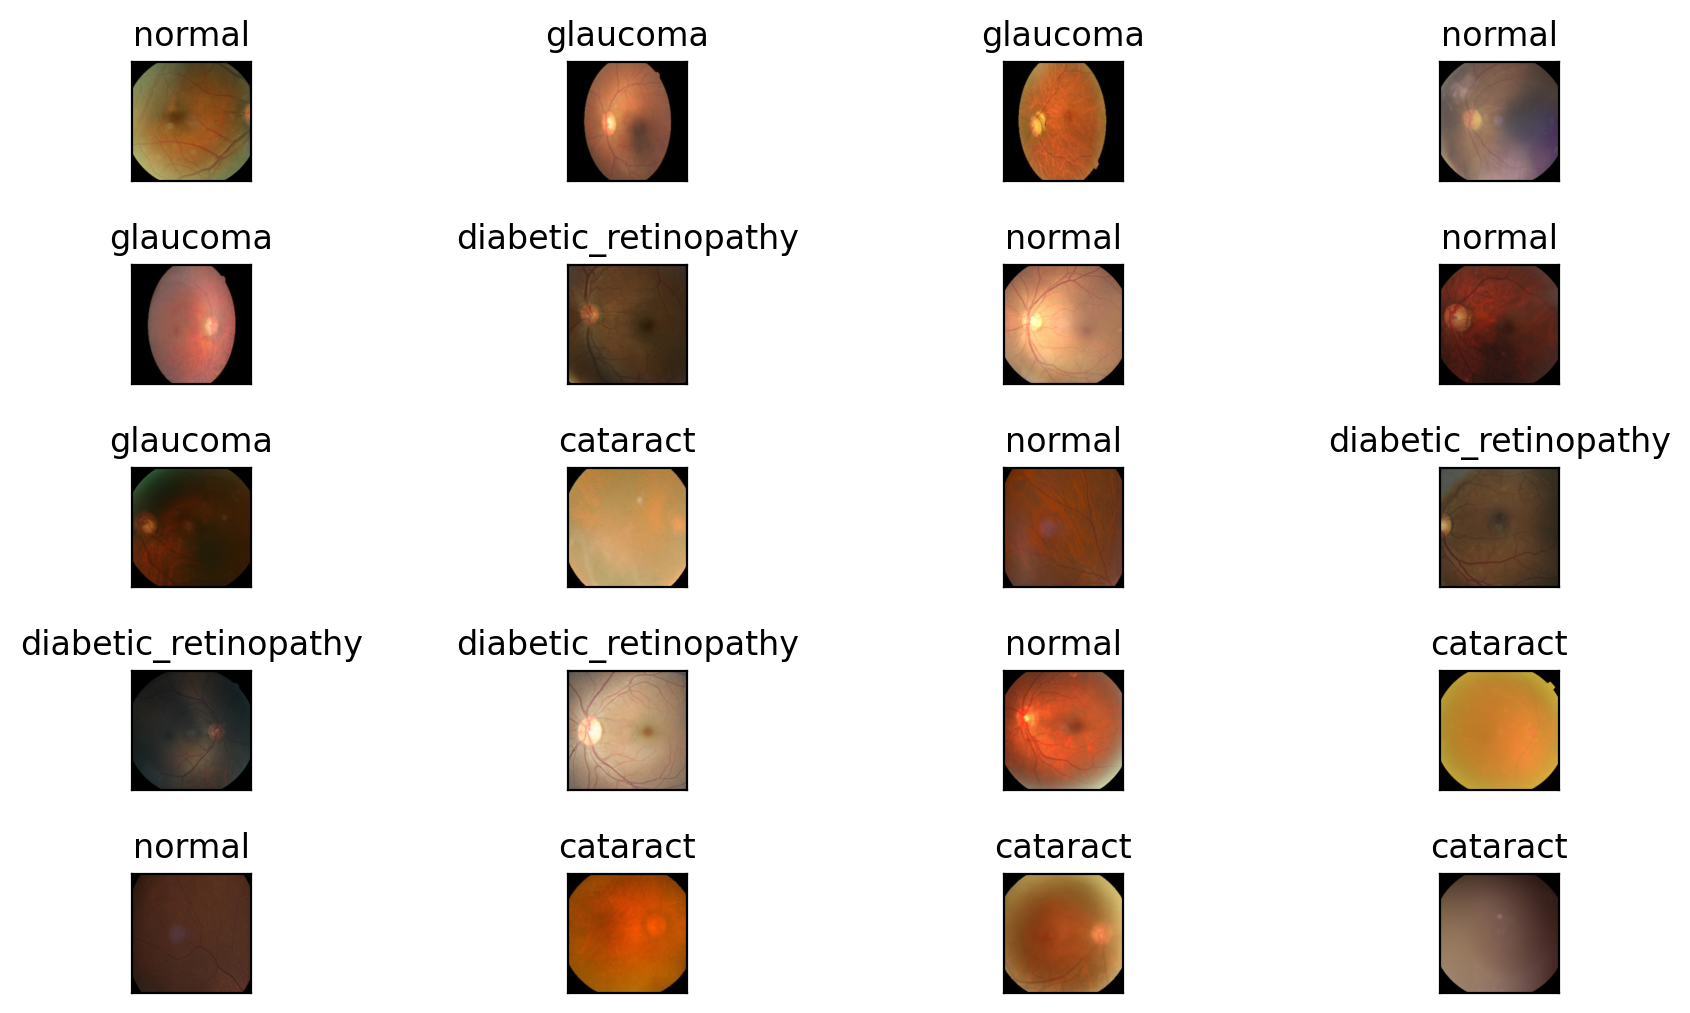

In [ ]:
# Displaying a few training images
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Retrieve the first batch of data

fig = plt.figure(figsize=(10,10))
for idx in np.arange(20):
    ax = fig.add_subplot(8, 4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

plt.subplots_adjust(hspace=0.7, wspace=0.8)  # Adjust spacing between subplots


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = models.densenet201(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 142MB/s]


In [ ]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
#we have to change the last layer to have output shape of 4
print(model.classifier.in_features)
print(model.classifier.out_features)

1920
1000


In [ ]:
for param in model.parameters():
  param.requires_grad = False


In [ ]:
n_inputs = model.classifier.in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier = last_layer
print(model.classifier.out_features)


4


In [ ]:
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
#defining optimizer and loss function
criterion = nn.CrossEntropyLoss() #loss function
optimizer = optim.Adam(model.classifier.parameters())

In [ ]:
#training the model
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [ ]:
#Using the features of pytorch ignite
trainer = create_supervised_trainer(model,optimizer,criterion,device=device)
evaluator = create_supervised_evaluator(model,
                                        device=device,
                                        metrics = {
                                            'accuracy' : Accuracy(),
                                            'loss' : Loss(criterion),
                                            'cm': ConfusionMatrix(len(classes))
                                        })
#creating event handlers to show training progress
@trainer.on(Events.ITERATION_COMPLETED)
def log_a_dot(engine):
  print(".",end = " ")

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
  evaluator.run(train_loader)
  metrics = evaluator.state.metrics
  accuracy = metrics['accuracy']*100
  loss = metrics['loss']
  training_history['accuracy'].append(accuracy)
  training_history['loss'].append(loss)
  print()
  print(f"Taining results - Epoch: {trainer.state.epoch} Avg Accuracy: {accuracy} Loss: {loss}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
  evaluator.run(val_loader)
  metrics = evaluator.state.metrics
  accuracy = metrics['accuracy']*100
  loss = metrics['loss']
  validation_history['accuracy'].append(accuracy)
  validation_history['loss'].append(loss)
  print()
  print(f"Validation results - Epoch: {trainer.state.epoch} Avg Accuracy: {accuracy} Loss: {loss}")



In [ ]:
trainer.run(train_loader,max_epochs=50)

. . . . . . . . . . . . . . . . . . 

In [ ]:
fig,axs = plt.subplots(2,2)
fig.set_figheight(6)
fig.set_figwidth(14)
axs[0,0].plot(traning_history["accuracy"])
axs[0,0].set_title("Training Accuracy")
axs[0,0].plot(validation_history["accuracy"])
axs[0,0].set_title("Validation Accuracy")
axs[0,0].plot(traning_history["loss"])
axs[0,0].set_title("Training loss")
axs[0,0].plot(validation_history["loss"])
axs[0,0].set_title("Validation loss")